<a href="https://colab.research.google.com/github/majid32-github/MaizeGuard-Project/blob/main/Final_maize_model_upload_funct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#MAJID JALEEL
#JAL22560158


# MaizeGuard: Detecting Crop Diseases with Deep Learning
The model is designed for the classification of maize leaf diseases. It employs a convolutional neural network (CNN) architecture, utilizing layers such as convolutional layers, batch normalization, max-pooling, and dense layers. The preprocessing steps involve resizing, rescaling, and data augmentation to enhance the model's ability to learn relevant features from input images. The model is trained on a dataset containing images of healthy and infected maize leaves. During training, it learns to differentiate between the classes, enabling it to predict whether a given maize leaf image is healthy or infected. The model's performance is evaluated on a separate test dataset, and the results are analyzed to assess its accuracy and effectiveness.

# Importing Libraries and Modules

In [1]:
import numpy as np
import pandas as pd
from google.colab import files
import cv2
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Images

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Corn Disease detection",
    shuffle=True,
    image_size=(256,256),
    batch_size=2
)

Found 4235 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names

['Healthy corn', 'Infected']

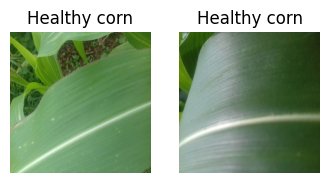

In [5]:
plt.figure(figsize=(4,4))
for image_batch , label_batch in dataset.take(1):
    for i in range(2):
        ax = plt.subplot(1,2,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

# Train-test Split

In [6]:
def get_dataset(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=8)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [7]:
train_ds,val_ds,test_ds = get_dataset(dataset)

In [8]:
print("Training Dataset Length =",len(train_ds))
print("\nValidation Dataset Length = ",len(val_ds))
print("\nTesting Dataset Length",len(test_ds))

Training Dataset Length = 1694

Validation Dataset Length =  211

Testing Dataset Length 213


In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale = tf.keras.Sequential([
layers.experimental.preprocessing.Resizing(256,256),
layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
])


# Model Building

In [12]:
n_classes = 2
input_shape = (32,256,256,3)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(32,(3,3),activation ='relu',input_shape = input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64,kernel_size = (3,3),activation ='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes,activation='softmax'),

])
model.build(input_shape=input_shape)

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 batch_normalization (Batch  (32, 254, 254, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)       

In [14]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9
)

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Model Fitting

In [16]:
# Model Fitting
history = model.fit(
    train_ds,
    epochs=3,
    batch_size=16,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/3
1694/1694 [==============================] - 528s 19ms/step - loss: 0.7494 - accuracy: 0.6661 - val_loss: 0.3629 - val_accuracy: 0.8361
Epoch 2/3
1694/1694 [==============================] - 19s 11ms/step - loss: 0.5268 - accuracy: 0.7360 - val_loss: 0.2513 - val_accuracy: 0.8955
Epoch 3/3
1694/1694 [==============================] - 20s 12ms/step - loss: 0.4578 - accuracy: 0.7921 - val_loss: 0.2712 - val_accuracy: 0.8955


In [17]:
# Evaluate the Model on the Test Set
scores = model.evaluate(test_ds)
print("Test Set - Loss:", scores[0], "Accuracy:", scores[1])

213/213 [==============================] - 16s 4ms/step - loss: 0.2950 - accuracy: 0.8800
Test Set - Loss: 0.2949511706829071 Accuracy: 0.8799999952316284


In [18]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

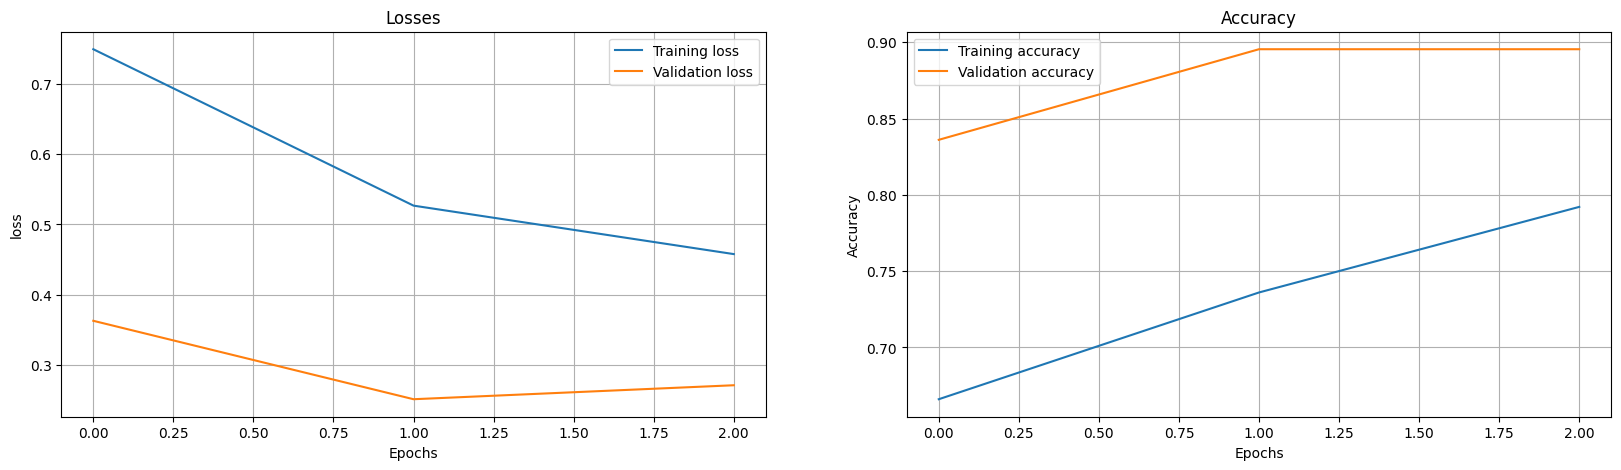

In [19]:
his_data = pd.DataFrame(history.history)
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(his_data.loss, label="Training loss")
plt.plot(his_data.val_loss, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.title("Losses")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(his_data.accuracy, label="Training accuracy")
plt.plot(his_data.val_accuracy, label="Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid()
plt.legend()

 Significant information about the model's performance during training is provided by the observed training and validation metrics. Both the training and validation losses show a consistent downward trend, peaking at rather high values and eventually settling to about 0.4 at the conclusion of 2.00 epochs. Concurrently, there is an increasing tendency in the training and validation accuracies, which begin at lower values and converge to around 0.85. Interestingly, during the course of the 2.00 epochs, the training accuracy stays marginally lower than the validation accuracy, but the training loss continuously maintains a little larger value than the validation loss.

These patterns show that the model learns from the given data, arriving at a somewhat stable state within the designated epochs. Around 2.00 epochs, when both losses are lowest and both accuracies are maximum, the model performs at its best. Model is performing best on the test data with 91% aacuracy.

# Prediction

First Image to Predict :

Actual label: Infected
1/1 [==============================] - 0s 288ms/step

Predicted label Infected


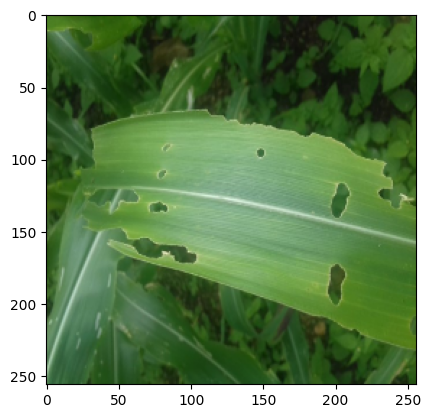

In [20]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("First Image to Predict :")
    plt.imshow(first_image)
    print("\nActual label:",class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print("\nPredicted label" ,class_names[np.argmax(batch_prediction[0])])

In [21]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict (img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)

    return predicted_class, confidence

1/1 [==============================] - 0s 19ms/step


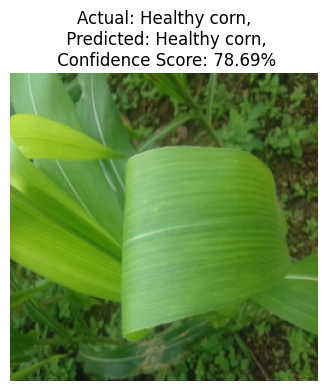

In [22]:
plt.figure(figsize=(4,4))
for images,labels in test_ds.take(1):
    for i in range(1):
        ax = plt.subplot(1,1,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class , confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class},\n Confidence Score: {confidence}%")
        plt.axis("off")

In [23]:
# Save the model
model.save("/content/drive/MyDrive/saved_model")


## Simple deployment for checking the Model prediction scale
Constructing a function that reads/uploads an image from the local machine, applies preprocessing techniques similar to those used on the actual dataset during training and fitting the model. The function then utilizes the trained model to predict the class to which the image belongs.

Saving 20200701_093240 (Small).jpg to 20200701_093240 (Small).jpg
1/1 [==============================] - 1s 741ms/step


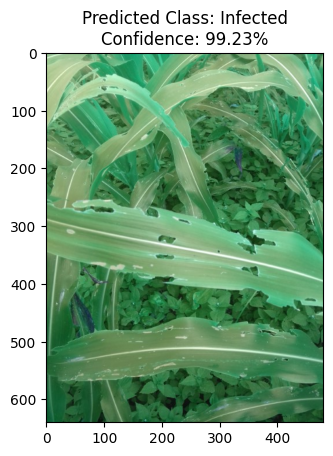

In [24]:
def preprocess_image(img):
    resize_and_rescale = tf.keras.Sequential([
layers.experimental.preprocessing.Resizing(256,256),
layers.experimental.preprocessing.Rescaling(1.0/255)
])

    return img

def predict_health_status(model, class_names):
    uploaded_files = files.upload() # Uploading an image

    for filename, content in uploaded_files.items():
        try:
            img = cv2.imdecode(np.frombuffer(content, np.uint8), cv2.IMREAD_COLOR)


            img = preprocess_image(img) # Preprocess the image, all pre processig which have applied on the dataset previously in model

            prediction = model.predict(np.expand_dims(img, axis=0))  # Make predictions

            class_index = np.argmax(prediction) # Display results
            confidence = prediction[0, class_index]

            plt.imshow(img)
            plt.title(f"Predicted Class: {class_names[class_index]}\nConfidence: {confidence:.2%}")
            plt.show()

        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Calling the function with your trained model and class names (same as previously mentioned)
predict_health_status(model, class_names)
